# Pre trained word embeddings

source : https://github.com/keras-team/keras/blob/master/examples/pretrained_word_embeddings.py

This script loads pre-trained word embeddings (GloVe embeddings)
into a frozen Keras Embedding layer, and uses it to
train a text classification model on pubblications

GloVe embedding data can be found at:
http://nlp.stanford.edu/data/glove.6B.zip
(source page: http://nlp.stanford.edu/projects/glove/)

FastText embedding data can be found at:
https://fasttext.cc/docs/en/english-vectors.html

Dict2vec embedding data can be found at:
https://github.com/tca19/dict2vec

Dict2vec publication : J. Tissier, C. Gravier, A. Habrard, Dict2vec : Learning Word Embeddings using Lexical Dictionaries

In [1]:
from __future__ import print_function

import os
import sys
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.initializers import Constant

cwd = os.getcwd()
BASE_DIR = r'D:\Users\Baptiste\Documents\Telecom_Saint-Etienne\FISE_3\PRI\Classification'
GLOVE_DIR = os.path.join(BASE_DIR, 'glove.6B\glove.6B.100d.txt')
FASTTEXT_DIR = os.path.join(BASE_DIR, 'fasttext\wiki-news-300d-1M-subword.vec')
DICT2VEC_DIR = os.path.join(BASE_DIR, 'dict2vec\dict2vec-vectors-dim100.vec')
TEXT_DATA_DIR = os.path.join(cwd, 'training_data')
MAX_SEQUENCE_LENGTH = 500
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
NUMBER_OF_USED_METADATA = 3

Using TensorFlow backend.


In [2]:
def load(fname):
    embeddings_index = {}
    with open(fname, encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index       
    

# Load embedding vector

first, build index mapping words in the embeddings set to their embedding vector

In [3]:
print('Indexing word vectors.')

#embeddings_index = load(GLOVE_DIR) #average results
#embeddings_index = load(FASTTEXT_DIR) #meh results
embeddings_index = load(DICT2VEC_DIR) #good results

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 132923 word vectors.


# Load the dataset

second, prepare text samples and their labels

In [4]:
import bibtexparser
from bibtexparser.bparser import BibTexParser
from latex_to_unicode import latex_to_unicode

#with open('training_data/codebasedcryptocayrelnet.bib') as bibtex_file:
#    bib_database = bibtexparser.load(bibtex_file)

print('Processing text dataset')

#texts = []  # list of text samples
x_title = []
x_keywords = []
x_booktitle = []
labels_index = {}  # dictionary mapping label name to numeric id
labels = []  # list of label ids

#name = "Articles_divers"
#label_id = len(labels_index)
#labels_index[name] = label_id
for name in sorted(os.listdir(TEXT_DATA_DIR)):
    path = os.path.join(TEXT_DATA_DIR, name)
    if os.path.isdir(path):
        label_id = len(labels_index)
        labels_index[name] = label_id
        for fname in sorted(os.listdir(path)):
            fpath = os.path.join(path, fname)
            with open(fpath) as bibtex_file:
                parser = BibTexParser(interpolate_strings=False)

                bib_database = bibtexparser.load(bibtex_file, parser)
                for publi in bib_database.entries:
                    #title = publi['title'].lower().replace("{}", "")
                    title = latex_to_unicode(publi['title']).lower()
                    if "keywords" in  publi:
                        keywords = latex_to_unicode(publi['keywords']).lower()
                        #keywords = publi['keywords'].lower().replace("{}", "")
                    else:
                        keywords = ""
                    if "booktitle" in  publi:
                        booktitle = latex_to_unicode(publi['booktitle']).lower()
                        #booktitle = publi['booktitle'].lower().replace("{}", "")
                    else:
                        booktitle = ""
                    x_title.append(title)
                    x_keywords.append(keywords)
                    x_booktitle.append(booktitle)
                    labels.append(label_id)
                    

# Classes
#name = "Articles_cryptographie"
#label_id = len(labels_index)
#labels_index[name] = label_id

#for publi in bib_database.entries:
#    title = publi['title'].lower().replace("{}", "")
#    texts.append(title)
#    labels.append(label_id)

print('Found %s texts.' % len(x_title))
print(labels_index)
print("0:", labels.count(0))
print("1:", labels.count(1))

Processing text dataset


Entry type thesis not standard. Not considered.
Entry type patent not standard. Not considered.
Cannot find unicode for SPACE WITH CEDILLA , using   instead
Cannot find unicode for SPACE WITH CEDILLA , using   instead
Cannot find unicode for SPACE WITH CEDILLA , using   instead
Cannot find unicode for SPACE WITH CEDILLA , using   instead
Cannot find unicode for SPACE WITH CEDILLA , using   instead
Cannot find unicode for SPACE WITH CEDILLA , using   instead
Cannot find unicode for SPACE WITH CEDILLA , using   instead


Found 679 texts.
{'Crypto': 0, 'Others': 1}
0: 416
1: 263


# Data augmentation

We use the data augmentation for the minority class

data augmentation: https://github.com/airbnb/artificial-adversary

In [5]:
from Adversary import Adversary

gen = Adversary() # for data augmentation

n_class0 = labels.count(0)
n_class1 = labels.count(1)

imax = max(n_class0, n_class1)

upsampl_class = 0
max_class = 1
n = 0
if imax == n_class0:
    upsampl_class = 1
    max_class = 0
    n = labels.index(1)
    
n_init = n

while labels.count(upsampl_class) < imax:
    
    title = x_title[n]
    keywords = x_keywords[n]
    booktitle = x_booktitle[n]
    label_id = labels[n]
    titleGen = []
    keywordsGen = []
    booktitleGen = []
    titleGen = gen.generate([title],text_sample_rate=5.0, word_sample_rate=0.5,
                                            attacks={'synonym':1})
    keywordsGen = gen.generate([keywords],text_sample_rate=5.0, word_sample_rate=0.5,
                            attacks={'synonym':1})
    booktitleGen = gen.generate([booktitle],text_sample_rate=5.0, word_sample_rate=0.5,
                            attacks={'synonym':1})
    x_title.append(titleGen[0][0])
    x_keywords.append(keywordsGen[0][0])
    x_booktitle.append(booktitleGen[0][0])
    labels.append(label_id)
    
    n += 1
    
    if n > n_init:
        n = n_init
    
print(labels_index)
print("0:", labels.count(0))
print("1:", labels.count(1))

{'Crypto': 0, 'Others': 1}
0: 416
1: 416


Then we use the data augmentation for the 2 classes

In [6]:
imax = len(labels)

for i in range(imax):
    
    title = x_title[i]
    keywords = x_keywords[i]
    booktitle = x_booktitle[i]
    label_id = labels[i]
    titleGen = []
    keywordsGen = []
    booktitleGen = []
    titleGen = gen.generate([title],text_sample_rate=5.0, word_sample_rate=0.5,
                                            attacks={'synonym':1})
    keywordsGen = gen.generate([keywords],text_sample_rate=5.0, word_sample_rate=0.5,
                            attacks={'synonym':1})
    booktitleGen = gen.generate([booktitle],text_sample_rate=5.0, word_sample_rate=0.5,
                            attacks={'synonym':1})
    x_title.append(titleGen[0][0])
    x_keywords.append(keywordsGen[0][0])
    x_booktitle.append(booktitleGen[0][0])
    labels.append(label_id)
    
print(labels_index)
print("0:", labels.count(0))
print("1:", labels.count(1))

{'Crypto': 0, 'Others': 1}
0: 832
1: 832


In [7]:
print('Dataset length: ', len(x_title))
print(labels_index)
print("0:", labels.count(0))
print("1:", labels.count(1))

Dataset length:  1664
{'Crypto': 0, 'Others': 1}
0: 832
1: 832


In [8]:

x_title

["security-related comments regarding mceliece 's public-key cryptosystem",
 'a new efficient threshold ring signature scheme based on coding theory',
 'a new zero-knowledge code based identification scheme with reduced\ncommunication',
 'susceptibility of digital signature schemes based on error-correcting\ncodes to universal forgery',
 'a digital signature scheme based on linear error-correcting block\ncodes',
 'security of xinmei digital signature scheme',
 'cryptanalysis of the harn and wang modification of the xinmei\ndigital signature scheme',
 'digital signature scheme based on error-correcting codes',
 'improved identity-based identification and signature schemes using\nquasi-dyadic goppa codes',
 'on constructing homomorphic encryption schemes from coding theory',
 'minimal vectors in linear codes',
 'sha-3 proposal : fsb',
 'a family of fast syndrome based cryptographic hash functions',
 'a fast provably secure cryptographic hash function',
 'side-channel attacks on the mceli

In [9]:
x_keywords

['',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',


In [10]:
#x_booktitle

# Vectorization

finally, vectorize the text samples into a 2D integer tensor

In [11]:
data = []
# titles
tokenizer_title = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer_title.fit_on_texts(x_title)
sequences_title = tokenizer_title.texts_to_sequences(x_title)

word_index = tokenizer_title.word_index
print('Found %s unique tokens.' % len(word_index))

data_title = pad_sequences(sequences_title, maxlen=MAX_SEQUENCE_LENGTH)

# keywords
tokenizer_keywords = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer_keywords.fit_on_texts(x_keywords)
sequences_keywords = tokenizer_keywords.texts_to_sequences(x_keywords)

word_index = tokenizer_keywords.word_index
print('Found %s unique tokens.' % len(word_index))

data_keywords = pad_sequences(sequences_keywords, maxlen=MAX_SEQUENCE_LENGTH)

# booktitle
tokenizer_booktitle = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer_booktitle.fit_on_texts(x_booktitle)
sequences_booktitle = tokenizer_booktitle.texts_to_sequences(x_booktitle)

word_index = tokenizer_booktitle.word_index
print('Found %s unique tokens.' % len(word_index))

data_booktitle = pad_sequences(sequences_booktitle, maxlen=MAX_SEQUENCE_LENGTH)

###

data.append(data_title)
data.append(data_keywords)
data.append(data_booktitle)

data = np.moveaxis(data,0,1)
data = np.reshape(data,[len(x_title),MAX_SEQUENCE_LENGTH*NUMBER_OF_USED_METADATA])

data = np.array(data)

labels_categorical = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels_categorical.shape)

Found 2074 unique tokens.
Found 1768 unique tokens.
Found 1012 unique tokens.
Shape of data tensor: (1664, 1500)
Shape of label tensor: (1664, 2)


# Split the dataset

split the data into a training set and a validation set

In [12]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(data, labels_categorical, test_size=VALIDATION_SPLIT, 
                                                  random_state=0, stratify=labels_categorical)


In [13]:
print('Preparing embedding matrix.')
# prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH*NUMBER_OF_USED_METADATA,
                            trainable=False)

Preparing embedding matrix.


# Create training model

In [14]:
print('Create training model.')

# train a 1D convnet with global maxpooling
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH*NUMBER_OF_USED_METADATA,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(len(labels_index), activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

Create training model.


In [15]:
print(*[bla.shape for bla in [x_train, x_val, y_train, y_val]], sep="\n")

(1331, 1500)
(333, 1500)
(1331, 2)
(333, 2)


In [16]:
y_train[:10]

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

# Train the model

In [17]:
import matplotlib.pyplot as plt

print('Training model')

history = model.fit(x_train, y_train,
          batch_size=128,
          epochs=10,
          validation_data=(x_val, y_val))

Training model
Train on 1331 samples, validate on 333 samples
Epoch 1/10
1331/1331 [==============================] - 4s 3ms/step - loss: 0.7023 - acc: 0.6146 - val_loss: 0.5159 - val_acc: 0.6877
Epoch 2/10
1331/1331 [==============================] - 1s 687us/step - loss: 0.4704 - acc: 0.7468 - val_loss: 0.4315 - val_acc: 0.7568
Epoch 3/10
1331/1331 [==============================] - 1s 693us/step - loss: 0.4415 - acc: 0.8107 - val_loss: 0.6036 - val_acc: 0.6216
Epoch 4/10
1331/1331 [==============================] - 1s 696us/step - loss: 0.2692 - acc: 0.8911 - val_loss: 0.6718 - val_acc: 0.6517
Epoch 5/10
1331/1331 [==============================] - 1s 702us/step - loss: 0.3352 - acc: 0.8843 - val_loss: 0.2747 - val_acc: 0.8709
Epoch 6/10
1331/1331 [==============================] - 1s 693us/step - loss: 0.2023 - acc: 0.9226 - val_loss: 0.2399 - val_acc: 0.8949
Epoch 7/10
1331/1331 [==============================] - 1s 698us/step - loss: 0.2112 - acc: 0.9144 - val_loss: 0.2396 - val_

# Plot the result

plot model


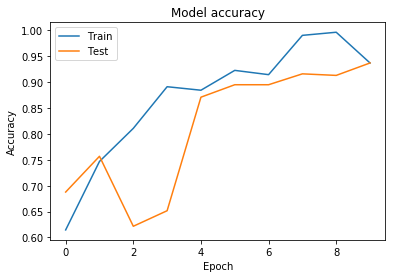

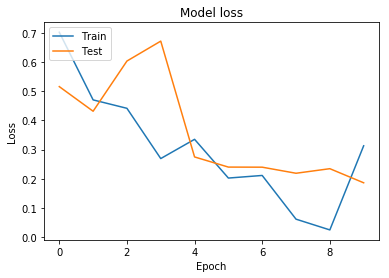

In [18]:
print('plot model')

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Save the model

In [19]:
import pickle

# https://www.opencodez.com/python/text-classification-using-keras.htm
# Below code saves the model as well as tokenizer. We have to save our tokenizer because it is our vocabulary.
# The same tokenizer and vocabulary have to be used for accurate prediction.

# creates a HDF5 file
model.save('model.h5')
# Save Tokenizer i.e. Vocabulary
with open('tokenizer_title.pickle', 'wb') as handle:
    pickle.dump(tokenizer_title, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('tokenizer_keywords.pickle', 'wb') as handle:
    pickle.dump(tokenizer_keywords, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('tokenizer_booktitle.pickle', 'wb') as handle:
    pickle.dump(tokenizer_booktitle, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Load the model

See Predict.ipbn

# Display the confusion matrix

In [20]:
# Run classifier
y_pred = model.predict(x_val)

# convert output label: one hot encodeing -> integer encoding e.g.: [0, 0, 1] -> 2
y_pred_encoded = np.argmax(y_pred, -1)
y_val_encoded = np.argmax(y_val , -1)

In [21]:
y_val_encoded

array([1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,

In [22]:
from sklearn.metrics import classification_report

print(classification_report(y_val_encoded, y_pred_encoded, target_names=labels_index))

# Precision : how many selected items are relevant?
# Recall : how many relevant items are selected?

              precision    recall  f1-score   support

      Crypto       0.92      0.95      0.94       166
      Others       0.95      0.92      0.94       167

   micro avg       0.94      0.94      0.94       333
   macro avg       0.94      0.94      0.94       333
weighted avg       0.94      0.94      0.94       333



Confusion matrix, without normalization
[[158   8]
 [ 13 154]]
Normalized confusion matrix
[[0.95 0.05]
 [0.08 0.92]]


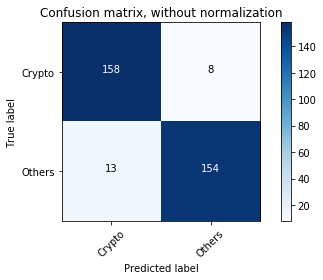

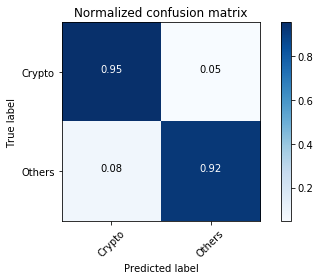

In [23]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_val_encoded, y_pred_encoded)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=labels_index,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=labels_index, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# Display wrongly classified articles

In [24]:
# Run classifier
y_pred = model.predict(data)

# convert output label: one hot encodeing -> integer encoding e.g.: [0, 0, 1] -> 2
y_pred_encoded = np.argmax(y_pred, -1)
y_val_encoded = np.argmax(labels_categorical , -1)
n = []
for i in range(len(y_pred_encoded)):
    if y_val_encoded[i] != y_pred_encoded[i]:
        n.append(i)



In [25]:
print("")
print(labels_index)
print("")


{'Crypto': 0, 'Others': 1}



In [26]:
print("Number of wrongly classified articles: ", len(n))
print("Number of articles: ", len(data))
print("")
print(labels_index)
print("")
for k in n:
    print("True class: ", y_val_encoded[k])
    print("Predicted class: ", y_pred_encoded[k])
    print("Title:", x_title[k])
    print("Booktitle:",x_booktitle[k])
    print("Keywords:",x_keywords[k])
    print("")

Number of wrongly classified articles:  22
Number of articles:  1664

{'Crypto': 0, 'Others': 1}

True class:  0
Predicted class:  1
Title: efficient lattice hibe in the standard model with shorter public parameters
Booktitle: 2nd information and communication technology - eurasia conference (ict-eurasia)
Keywords: lattice ; hierarchical identity base encryption (hibe) ; learning with error (lwe)

True class:  0
Predicted class:  1
Title: list-decoding of binary goppa codes up to the binary johnson bound
Booktitle: 
Keywords: error correcting codes ; list decoding ; binary goppa codes

True class:  0
Predicted class:  1
Title: evaluation of format- preserving encryption algorithms for critical infrastructure protection
Booktitle: 8th international conference on critical infrastructure protection (iccip)
Keywords: format-preserving encryption ; legacy infrastructure assets

True class:  0
Predicted class:  1
Title: représentation en objets vidéo pour un codage progressif et concurrentie

In [27]:
labels_index.get('Crypto')

0